In [1]:
import logging
import argparse
import os
import random
import numpy as np

from datetime import timedelta

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

#from apex import amp
#from apex.parallel import DistributedDataParallel as DDP

from models.modeling import VisionTransformer, CONFIGS
from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import get_world_size

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm

import logging

import torch
import torch.nn as nn

import math

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

In [2]:
img_size = 224

transform_train = transforms.Compose([
    transforms.RandomResizedCrop((img_size, img_size), scale=(0.05, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

trainset = datasets.CIFAR10(root="./data",
                            train=True,
                            download=True,
                            transform=transform_train)
testset = datasets.CIFAR10(root="./data",
                           train=False,
                           download=True,
                           transform=transform_test)

train_sampler = RandomSampler(trainset)# if args.local_rank == -1 else DistributedSampler(trainset)
test_sampler = SequentialSampler(testset)

train_loader = DataLoader(trainset,
                          sampler=train_sampler,
                          batch_size=4,
                          num_workers=4)
test_loader = DataLoader(testset,
                         sampler=test_sampler,
                         batch_size=1,
                         num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        img_size = _pair(img_size)


        patch_size = _pair(config.patches["size"])
        n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.hybrid = False

        self.patch_embeddings = Conv2d(in_channels=3,
                                       out_channels=768,
                                       kernel_size=(16, 16),
                                       stride=(16, 16))
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        B = x.shape[0]     # 1
        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.hybrid:
            x = self.hybrid_model(x)
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

In [14]:
config = CONFIGS['R50-ViT-B_16']

CONFIGS = {
    'ViT-B_16': configs.get_b16_config(),
    'ViT-B_32': configs.get_b32_config(),
    'ViT-L_16': configs.get_l16_config(),
    'ViT-L_32': configs.get_l32_config(),
    'ViT-H_14': configs.get_h14_config(),
    'R50-ViT-B_16': configs.get_r50_b16_config(),
    'testing': configs.get_testing(),
}

embedding = Embeddings(config, img_size)

embedding_output = embedding(input_)

# patch embedding + position embedding

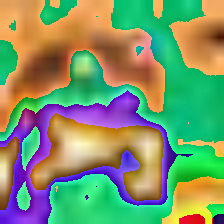

In [43]:
transforms.ToPILImage()(trainset[0][0])

In [56]:
input_ = trainset[0][0].unsqueeze(0)
B = input_.shape[0]
print("Input Size : {}".format(input_.size()))

Input Size : torch.Size([1, 3, 224, 224])


In [54]:
input_ = trainset[0][0].unsqueeze(0)
B = input_.shape[0]

n_patches=196

dropout_ = Dropout(config.transformer["dropout_rate"])
position_embeddings_ = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size)) # (1, 197, 768)
cls_tokens_ = nn.Parameter(torch.zeros(1, 1, config.hidden_size))
cls_tokens = cls_tokens_.expand(B, -1, -1)

patch_embeddings_ =  Conv2d(in_channels=3,
                            out_channels=768,
                            kernel_size=(16, 16),
                            stride=(16, 16))

x = patch_embeddings_(input_)           #  in paper  Linear Projection of Flattened Patches


x = x.flatten(2)
x = x.transpose(-1, -2)
x = torch.cat((cls_tokens, x), dim=1)   # (1, 197, 768)

embeddings = x + position_embeddings_   # position embeddings -> patch에 위치정보 부여
embeddings = dropout_(embeddings)       # (1, 197, 768)

In [60]:
patch_embeddings_ =  Conv2d(in_channels=3,
                            out_channels=768,
                            kernel_size=(16, 16),
                            stride=(16, 16))

x = patch_embeddings_(input_)           #  in paper  Linear Projection of Flattened Patches

In [61]:
cls_tokens_ = nn.Parameter(torch.zeros(1, 1, config.hidden_size))
cls_tokens = cls_tokens_.expand(B, -1, -1)

x = x.flatten(2)
x = x.transpose(-1, -2)
x = torch.cat((cls_tokens, x), dim=1)   # (1, 197, 768)
print(x.size())

torch.Size([1, 197, 768])


In [63]:
dropout_ = Dropout(config.transformer["dropout_rate"])
position_embeddings_ = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size)) # (1, 197, 768)

embeddings = x + position_embeddings_   # position embeddings -> patch에 위치정보 부여
embeddings = dropout_(embeddings)       # (1, 197, 768)
print(embeddings.size())

torch.Size([1, 197, 768])


In [23]:
hybrid_model = ResNetV2(block_units=config.resnet.num_layers,
                                         width_factor=config.resnet.width_factor)

# Transformer Encoder

# Multi-head Attention

In [78]:
def transpose_for_scores(x):
    new_x_shape = x.size()[:-1] + (num_attention_heads, attention_head_size)
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)


vis = True
num_attention_heads = config.transformer["num_heads"]                 # 12
attention_head_size = int(config.hidden_size / num_attention_heads)   # 64
all_head_size = num_attention_heads * attention_head_size             # 768

query_ = Linear(config.hidden_size, all_head_size)                    #  (768, 768)
key_ = Linear(config.hidden_size, all_head_size)
value_ = Linear(config.hidden_size, all_head_size)

out_ = Linear(config.hidden_size, config.hidden_size)                  #  (768, 768)
attn_dropout_ = Dropout(config.transformer["attention_dropout_rate"])  # 0
proj_dropout_ = Dropout(config.transformer["attention_dropout_rate"])  # 0

softmax_ = Softmax(dim=-1)


attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)


h = embeddings
embeddings = attention_norm(embeddings)

mixed_query_layer = query_(embeddings)
mixed_key_layer = key_(embeddings)
mixed_value_layer = value_(embeddings) # 1, 197, 768

print(mixed_query_layer.size(), mixed_key_layer.size(), mixed_value_layer.size())

torch.Size([1, 197, 768]) torch.Size([1, 197, 768]) torch.Size([1, 197, 768])


In [79]:
attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))  # 1, 12, 197, 197
attention_scores_ = attention_scores / math.sqrt(attention_head_size)
attention_probs = softmax_(attention_scores_)
weights = attention_probs if vis else None

attention_probs = attn_dropout_(attention_probs)                            # 1, 12, 197, 197

context_layer = torch.matmul(attention_probs, value_layer)                 # 1, 12, 197, 64
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()             # 1, 197, 12, 64

new_context_layer_shape = context_layer.size()[:-2] + (all_head_size,)     # 1, 197, 768

context_layer = context_layer.view(*new_context_layer_shape)               # 1, 197, 768

attention_output = out_(context_layer)
attention_output = proj_dropout_(attention_output)

x = attention_output + h

print(x.size())

torch.Size([1, 197, 768])


# mlp

In [32]:
def _init_weights():
    nn.init.xavier_uniform_(fc1.weight)
    nn.init.xavier_uniform_(fc2.weight)
    nn.init.normal_(fc1.bias, std=1e-6)
    nn.init.normal_(fc2.bias, std=1e-6)

fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
act_fn = torch.nn.functional.gelu
dropout = Dropout(config.transformer["dropout_rate"])

ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)

_init_weights()

In [80]:
def _init_weights():
    nn.init.xavier_uniform_(fc1.weight)
    nn.init.xavier_uniform_(fc2.weight)
    nn.init.normal_(fc1.bias, std=1e-6)
    nn.init.normal_(fc2.bias, std=1e-6)

fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
act_fn = torch.nn.functional.gelu
dropout = Dropout(config.transformer["dropout_rate"])
ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
_init_weights()



h = x
x = ffn_norm(x)

x = fc1(x)
x = act_fn(x)
x = dropout(x)
x = fc2(x)
x = dropout(x)

x = x + h

print(x.size())

torch.Size([1, 197, 768])
